## Imports

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LocallyConnected2D
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image

## Simple DeepFace Model

In [7]:
def deepface(input_shape=None):
    input_data = Input(shape=input_shape)
    
    conv1 = Conv2D(32, (11, 11), activation='relu', name='C1')(input_data)
    maxpool1 = MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2')(conv1)
    conv2 = Conv2D(16, (9, 9), activation='relu', name='C3')(maxpool1)
    lconv1 = LocallyConnected2D(16, (9, 9), activation='relu', name='L4')(conv2)
    lconv2 = LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5')(lconv1)
    lconv3 = LocallyConnected2D(16, (5, 5), activation='relu', name='L6')(lconv2)
    flat = Flatten(name='F0')(lconv3)
    fc1 = Dense(4096, activation='relu', name='F7')(flat)
    drop = Dropout(rate=0.5, name='D0')(fc1)
    fc2 = Dense(8631, activation='softmax', name='F8')(drop)
    
    model = Model(inputs=input_data, outputs=fc2, name="DeepFace")
    
    return model
    

In [8]:
model = deepface(input_shape=(152, 152, 3))

In [9]:
model.summary()

Model: "DeepFace"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 152, 152, 3)]     0         
_________________________________________________________________
C1 (Conv2D)                  (None, 142, 142, 32)      11648     
_________________________________________________________________
M2 (MaxPooling2D)            (None, 71, 71, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 63, 63, 16)        41488     
_________________________________________________________________
L4 (LocallyConnected2D)      (None, 55, 55, 16)        62774800  
_________________________________________________________________
L5 (LocallyConnected2D)      (None, 25, 25, 16)        7850000   
_________________________________________________________________
L6 (LocallyConnected2D)      (None, 21, 21, 16)        282

Due to locally connected conv2d there is so many parameters to learn. To train it from scratch is hard. So i am going to load pretrained weight of deep face trained on VGGFace2 dataset

In [10]:
model.load_weights('./weights/VGGFace2_DeepFace_weights_val-0.9034.h5')

Now we no more need that last layers for get representation vector.So we cut out the last layer

In [12]:
deepface = Model(inputs=model.layers[0].input, outputs=model.layers[-3].output)

In [13]:
deepface.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 152, 152, 3)]     0         
_________________________________________________________________
C1 (Conv2D)                  (None, 142, 142, 32)      11648     
_________________________________________________________________
M2 (MaxPooling2D)            (None, 71, 71, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 63, 63, 16)        41488     
_________________________________________________________________
L4 (LocallyConnected2D)      (None, 55, 55, 16)        62774800  
_________________________________________________________________
L5 (LocallyConnected2D)      (None, 25, 25, 16)        7850000   
_________________________________________________________________
L6 (LocallyConnected2D)      (None, 21, 21, 16)        2829

## Comparing representations
The output of the deepface is 4096 dimensional vector (embedding). `Euclidean distance` in L2 form is used to find the similarity between two vectors in the original paper.

In [14]:
def l2_normalization(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

In [18]:
def Euclidean_Distance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [19]:
def Cosine_Distance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

## Detecting Face

In [22]:
# initializing th classifiers
cascPath=os.path.dirname(cv2.__file__)+"/data/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

In [23]:
def detect_face(img_path, target_size=(152, 152)):
    img = cv2.imread(img_path)
    faces = faceCascade.detectMultiScale(img, 1.3, 5)
    
    if len(faces) > 0:
        x,y,w,h = faces[0]
        
        margin = 0
        x_margin = w * margin / 100
        y_margin = h * margin / 100
        
        if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
            detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
        else:
            detected_face = img[int(y):int(y+h), int(x):int(x+w)]
        
        detected_face = cv2.resize(detected_face, target_size)
        
        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        
        #normalize in [0, 1]
        img_pixels /= 255 
        
        return img_pixels
    else:
        raise ValueError("Face could not be detected in ", img_path,". Please confirm that the picture is a face photo.")

## Face Verification

In [73]:
img1 = 'test/rdj1.jpg'
img2 = 'test/rdj2.jpeg'

In [74]:
def verify(img1, img2):
    face1 = detect_face(img1)
    face2 = detect_face(img2)
    
    face1_embedding = deepface.predict(face1)[0] #4096 dimensional output
    face2_embedding = deepface.predict(face2)[0] #4096 dimensional output

    # Cosine Distance
    cosine_distance = Cosine_Distance(face1_embedding, face2_embedding)
    cosine_l2_distance = Cosine_Distance(l2_normalization(face1_embedding), l2_normalization(face1_embedding))

    # Euclidean Distance
    euclidean_distance = Euclidean_Distance(face1_embedding, face2_embedding)
    euclidean_l2_distance = Euclidean_Distance(l2_normalization(face1_embedding), l2_normalization(face2_embedding))

    print("Cosine distance: ", cosine_distance)
    print("Cosine L2 distance: ", cosine_l2_distance)

    print("Euclidean distance: ", euclidean_distance)
    print("Euclidean L2 distance: ", euclidean_l2_distance)

    if euclidean_l2_distance <= 0.55:
        verified = True
    else:
        verified = False
    
    if verified:
        print("Two faces are of same person.")
        print("Verified!!!")

        fig = plt.figure()
        fig.add_subplot(1,2, 1)
        plt.imshow(face1[0][:, :, ::-1])
        plt.xticks([]); plt.yticks([])
        fig.add_subplot(1,2, 2)
        plt.imshow(face2[0][:, :, ::-1])
        plt.xticks([]); plt.yticks([])
        plt.show(block=True)
    
    else:
        print("Two faces are not  of same person.")
        print("Not Verified !!!")
        
        fig = plt.figure()
        fig.add_subplot(1,2, 1)
        plt.imshow(face1[0][:, :, ::-1])
        plt.xticks([]); plt.yticks([])
        fig.add_subplot(1,2, 2)
        plt.imshow(face2[0][:, :, ::-1])
        plt.xticks([]); plt.yticks([])
        plt.show(block=True)
    


Cosine distance:  0.12314891815185547
Cosine L2 distance:  -1.1920928955078125e-07
Euclidean distance:  59.09087
Euclidean L2 distance:  0.49628407
Two faces are of same person.
Verified!!!


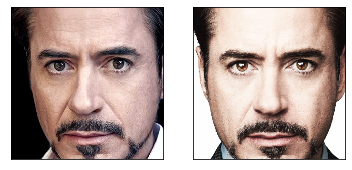

In [75]:
verify(img1, img2)